# Finding Predicted and Actual Mass

In [8]:
import numpy as np

def prediction(halo, ratio=0.5):
    output = ''
    # Find r_half (radius where half of the all star mass is)...

    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_3DR())
    # Get the total mass of all stars
    TOTAL_STAR_MASS = np.sum([star.m for star in sorted_stars])
    output += (f"Total Star Mass: {round(TOTAL_STAR_MASS,2)} M☉\n")
    # Go through stars until half of the mass is enclosed
    enclosed_mass, star_index = 0, 0
    while True:
        enclosed_mass += sorted_stars[star_index].m
        star_index += 1
        if enclosed_mass >= TOTAL_STAR_MASS * ratio: break

    # The radius of the star at star_index is the half mass radius
    r_half = sorted_stars[star_index].get_3DR()
    output += (f"r_{ratio}: {round(r_half,2)} kpc at star {star_index} with mass {round(enclosed_mass,2)} M☉\n")

    included_stars = sorted_stars[:star_index]

    # Find <σ^2>...

    los_dispersion = np.std([star.vz for star in included_stars])
    luminosities = [star.m for star in included_stars]
    average = np.average([los_dispersion ** 2] * len(included_stars), weights=luminosities)

    # Plug and chug...

    G =  4.3 * 10**-6 
    prediction = 3 * pow(G, -1) * average * r_half
    output += (f"Predicted Total Mass: {prediction:.2e} M☉\n")
    output += '\n'
    
    return enclosed_mass, r_half, output, prediction 

def actual(halo, sim, enclosed_mass, r_half, output, predicted_mass): 
    # Find M_half (actual mass of every star, dark matter, and gas particle within r_half)

    # Get the star masses using stellar util
    star_masses = enclosed_mass
    output += (f"Star Masses by Hand:\t\t{ np.sum(star_masses):.2e} M☉\n")
    # Get the dm masses
    dark_x = sim.particles['dark']['position'][:,0] - halo.xc
    dark_y = sim.particles['dark']['position'][:,1] - halo.yc
    dark_z = sim.particles['dark']['position'][:,2] - halo.zc
    dark_m = sim.particles['dark']['mass']
    dark_distances = np.sqrt(np.square(dark_x) + np.square(dark_y) + np.square(dark_z))
    dark_masses = dark_m[dark_distances < r_half]
    output += (f"DM Masses by Hand:\t\t{ np.sum(dark_masses):.2e} M☉\n")
    # Get the gas masses
    gas_x = sim.particles['gas']['position'][:,0] - halo.xc
    gas_y = sim.particles['gas']['position'][:,1] - halo.yc
    gas_z = sim.particles['gas']['position'][:,2] - halo.zc
    gas_m = sim.particles['gas']['mass']
    gas_distances = np.sqrt(np.square(gas_x) + np.square(gas_y) + np.square(gas_z))
    gas_masses = gas_m[gas_distances < r_half]
    output += (f"Gas Masses by Hand:\t\t{ np.sum(gas_masses):.2e} M☉\n")

    actual_mass = np.sum(star_masses) + np.sum(dark_masses) + np.sum(gas_masses)
    output += (f"Total Mass by Hand:\t\t{actual_mass:.2e} M☉")
    output += (f"\nPercent Difference:\t\t{ round((abs(actual_mass - predicted_mass) / ((actual_mass + predicted_mass) / 2)) * 100) }%\n\n")
    
    
    return output


In [9]:
from stellarutil import Simulation
from IPython.display import clear_output

simName = "m10v_res250md"

def doJeansMass(simName, ratios=[0.5]):
    sim = Simulation(simulation_name=simName, species=['star', 'dark', 'gas'])
    clear_output()
    halo = sim.get_halo()

    for ratio in ratios:
        enclosed_mass, r_half, output, prediction = prediction(halo, ratio)
        output = actual(halo, sim, enclosed_mass, r_half, output, prediction)
        with open('../images/output.txt', 'a') as f:
            f.write('-' * 15 + "  " + simName + f" @ {ratio} * radius  " + '-' * 15 + '\n')
            f.write(output + '\n\n')


doJeansMass("m10v_res250md", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# doJeansMass("m10r_res250md", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# doJeansMass("m10q_res250md", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# doJeansMass("m10v_res030md")

UnboundLocalError: cannot access local variable 'prediction' where it is not associated with a value

# Graph Jeans at Different %s

../data/m10v_res250md/snapshot_600.z0.000.AHF_halos

# in gizmo_analysis.gizmo_io.Read():
* reading header from:  data/m10v_res250md/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 36851064 particles
    dark2     (id = 2): 13328409 particles
    gas       (id = 0): 36840830 particles
    star      (id = 4): 10234 particles
    blackhole (id = 5): 0 particles


# in utilities.simulation.Snapshot():
* reading:  data/m10v_res250md/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  data/m10v_res250md/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 36851064 particles
    dark2     (id = 2): 13328409 particles
    gas       (id = 0): 36840830 particles
    star      (id = 4): 10234 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'dark', 'gas']
  star proper

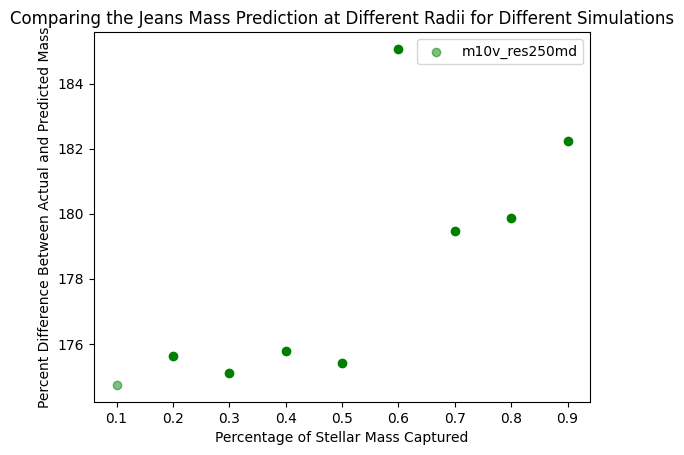

In [7]:
import numpy as np
import matplotlib.pyplot as plt

results = [] # sim name, ratio, pd
added_labels = []


def jeans(sim, ratio=0.5):
    halo = sim.get_halo()
    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_2DR())
    # Get the total mass of all stars
    TOTAL_STAR_MASS = np.sum([star.m for star in sorted_stars])
    # Go through stars until half of the mass is enclosed
    enclosed_mass, star_index = 0, 0
    while True:
        enclosed_mass += sorted_stars[star_index].m
        star_index += 1
        if enclosed_mass >= TOTAL_STAR_MASS * ratio: break

    # The radius of the star at star_index is the half mass radius
    r_half = sorted_stars[star_index].get_3DR()
    included_stars = sorted_stars[:star_index]

    # Find <σ^2>...
    los_dispersion = np.std([star.vz for star in included_stars])
    luminosities = [star.m for star in included_stars]
    average = np.average([los_dispersion ** 2] * len(included_stars), weights=luminosities)

    # Plug and chug...
    G =  4.3 * 10**-6 
    prediction = 3 * pow(G, -1) * average * r_half
    
    # Find M_half (actual mass of every star, dark matter, and gas particle within r_half)

    # Get the star masses using stellar util
    star_masses = enclosed_mass
    # Get the dm masses
    dark_x = sim.particles['dark']['position'][:,0] - halo.xc
    dark_y = sim.particles['dark']['position'][:,1] - halo.yc
    dark_z = sim.particles['dark']['position'][:,2] - halo.zc
    dark_m = sim.particles['dark']['mass']
    dark_distances = np.sqrt(np.square(dark_x) + np.square(dark_y) + np.square(dark_z))
    dark_masses = dark_m[dark_distances < r_half]
    # Get the gas masses
    gas_x = sim.particles['gas']['position'][:,0] - halo.xc
    gas_y = sim.particles['gas']['position'][:,1] - halo.yc
    gas_z = sim.particles['gas']['position'][:,2] - halo.zc
    gas_m = sim.particles['gas']['mass']
    gas_distances = np.sqrt(np.square(gas_x) + np.square(gas_y) + np.square(gas_z))
    gas_masses = gas_m[gas_distances < r_half]

    actual = np.sum(star_masses) + np.sum(dark_masses) + np.sum(gas_masses)
    
    return actual, prediction

def doJeansOnSim(simName, ratios=[0.5]):
    sim = Simulation(simulation_name=simName, species=['star', 'dark', 'gas'])
    for ratio in ratios:
        actual, prediction = jeans(sim, ratio)
        pd = abs(actual - prediction) / ((actual + prediction) / 2) * 100
        if simName == 'm10q_res250md':
            color = 'red'
            print("m10q_res250md", actual, prediction, pd)
        elif simName == 'm10v_res250md':
            color = 'green'
        elif simName == 'm10r_res250md':
            color = 'yellow'
            print("m10r_res250md", actual, prediction, pd)

        if simName not in added_labels:
            plt.scatter(ratio, pd, label=(simName), c=color, alpha=0.5)
            added_labels.append(simName)
        else:
            plt.scatter(ratio, pd, c=color)

        results.append([color, ratio, pd])

# doJeansOnSim("m10q_res250md", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# doJeansOnSim("m10r_res250md", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
doJeansOnSim("m10v_res250md", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


# clear_output()

# Plot y=x line
# Add labels and legend
plt.xlabel('Percentage of Stellar Mass Captured')
plt.ylabel('Percent Difference Between Actual and Predicted Mass')
plt.title("Comparing the Jeans Mass Prediction at Different Radii for Different Simulations")
plt.legend()
# Show the plot
plt.show()


In [1]:
def reverse_number(num):
  # Reverse the number
  reverse = num[::-1]
  # Return the number
  return reverse

## Example usage:
print(reverse_number(1223)) # Output: 3221
print(reverse_number(987654321)) # Output: 123456789


TypeError: 'int' object is not subscriptable

In [2]:
def reverse_number(num):
    # Convert the number to a string, reverse it, and convert back to an integer
    reverse = int(str(num)[::-1])
    # Return the reversed number
    return reverse

## Example usage:
print(reverse_number(1223))        # Output: 3221
print(reverse_number(987654321))   # Output: 123456789

3221
123456789
